In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns

Welcome to JupyROOT 6.19/01


In [2]:
signalFile=TFile.Open("samples/sig_nonres_bbtt.root")
backgroundFile=TFile.Open("samples/bkg_ttbar_dilepton.root")
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)
signalArray=signalTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
backgroundArray=backgroundTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

signal events number before cut is:  217248
background events number before cut is:  10995


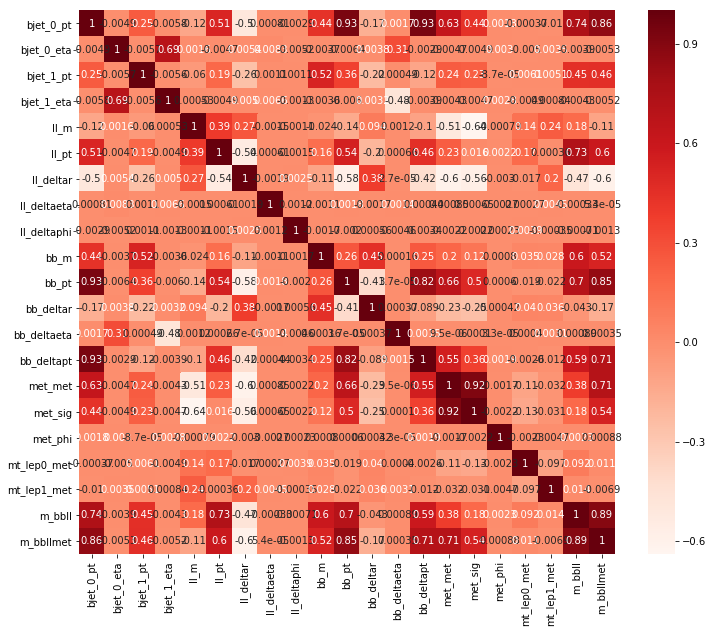

In [3]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(12,10))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

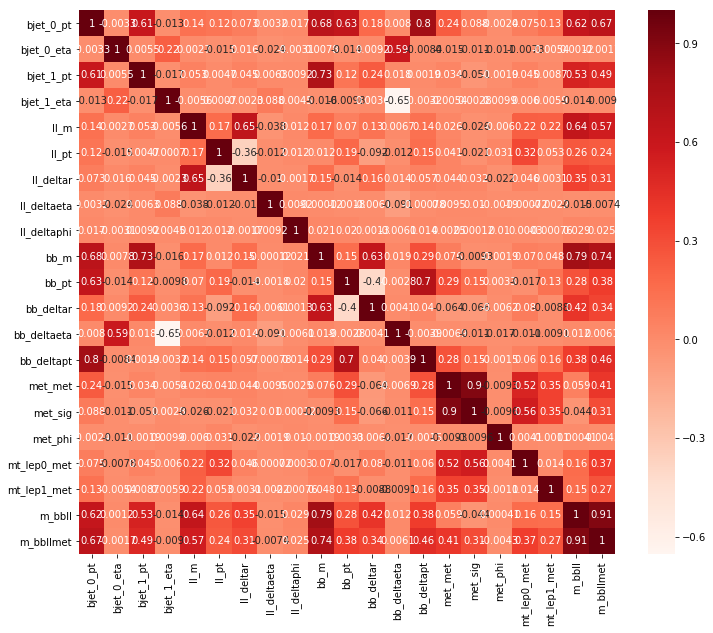

In [4]:
dataBackground=pd.DataFrame(data=backgroundArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(12,10))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


In [5]:
signalSample=signalArray#[(abs(signalArray[:,3])>2.0)&(signalArray[:,1]>300)]
backgroundSample=backgroundArray#[(abs(backgroundArray[:,3])>2.0)&(backgroundArray[:,1]>300)]

In [6]:
signaldf=pd.DataFrame(data=signalSample[:,1:])
normalize_df=(signaldf-signaldf.min())/(signaldf.max()-signaldf.min())
signalSample1=normalize_df.values
backgrounddf=pd.DataFrame(data=backgroundSample[:,1:])
normalize_df=(backgrounddf-backgrounddf.min())/(backgrounddf.max()-backgrounddf.min())
backgroundSample1=normalize_df.values
print(backgroundSample1)

[[0.1048238  0.50330782 0.08915562 ... 0.0885143  0.09467147 0.07783742]
 [0.19377055 0.29564217 0.24111472 ... 0.3229771  0.30668546 0.2640282 ]
 [0.04893508 0.73308935 0.04601364 ... 0.19212414 0.05945254 0.06798196]
 ...
 [0.13033736 0.76843606 0.00194335 ... 0.03767111 0.22142912 0.16110338]
 [0.0810195  0.34781338 0.04074328 ... 0.05596303 0.1327359  0.10465274]
 [0.09606173 0.32056755 0.14051585 ... 0.19238532 0.11342759 0.11192518]]


In [7]:
model=load_model('model_tt-zz.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


2019-06-23 01:58:27.444547: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-06-23 01:58:27.450805: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2019-06-23 01:58:27.451521: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x556cb66492c0 executing computations on platform Host. Devices:
2019-06-23 01:58:27.451545: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-06-23 01:58:27.514341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-06-23 01:58:27.514689: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x556cb66f8530 executing computations on platform CUDA. Devices:
2019-06-23 01:58:27.514714: I t

(array([1348.,  161., 2507.,  829.,  506.,  336.,  286.,  220.,  200.,
         172.,  154.,  164.,  208.,  234.,  257.,  272.,  311.,  465.,
         812., 1553.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

2019-06-23 01:58:30.461700: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


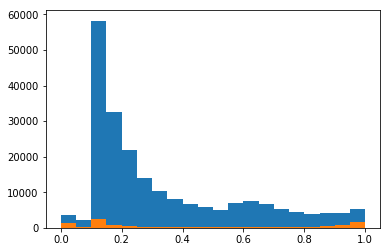

In [8]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)

In [9]:
plt.hist(signalNNScore,bins=20)

NameError: name 'signalNNScore' is not defined

In [10]:
cuda.select_device(0)
cuda.close()

In [ ]:
GBDT_zz = pickle.load(open("GBDT_HHttzz.pickle.dat", "rb"))
#GBDT_zz = pickle.load(open("GBDT_HHzzww.pickle.dat", "rb"))
#GBDT_ww = pickle.load(open("GBDT_HHww.pickle.dat", "rb"))

In [ ]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTSignal=xgb.DMatrix(signalArray[:,1:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundArray[:,1:],feature_names=varName)
#signalTTBDTScore=GBDT_tt.predict(BDTSignal)
#backgroundTTBDTScore=GBDT_tt.predict(BDTBackground)
signalZZBDTScore=GBDT_zz.predict(BDTSignal)
backgroundZZBDTScore=GBDT_zz.predict(BDTBackground)
#signalWWBDTScore=GBDT_ww.predict(BDTSignal)
#backgroundWWBDTScore=GBDT_ww.predict(BDTBackground)

In [ ]:
plt.hist(signalTTBDTScore,bins=20)
print(signalTTBDTScore)

In [11]:
signalFile.Close()
backgroundFile.Close()
signalFile=TFile.Open("samples/sig_nonres_bbtt.root","update")
backgroundFile=TFile.Open("samples/bkg_ttbar_dilepton.root","update")
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")
sZZBDT=array("f",[0])
sTTBDT=array("f",[0])
sWWBDT=array("f",[0])
bZZBDT=array("f",[0])
bTTBDT=array("f",[0])
bWWBDT=array("f",[0])
#sigZZBDTBranch=signalTree.Branch("BDT_ZZ_TT",sZZBDT,"BDT_ZZ_TT/F")
#sigWWBDTBranch=signalTree.Branch("BDT_WW",sWWBDT,"BDT_WW/F")
#sigTTBDTBranch=signalTree.Branch("BDT_TT_WW",sTTBDT,"BDT_TT_WW/F")
#bakZZBDTBranch=backgroundTree.Branch("BDT_ZZ_TT",bZZBDT,"BDT_ZZ_TT/F")
#bakWWBDTBranch=backgroundTree.Branch("BDT_WW",bWWBDT,"BDT_WW/F")
#bakTTBDTBranch=backgroundTree.Branch("BDT_TT_WW",bTTBDT,"BDT_TT_WW/F")
sn=array("f",[0])
bn=array("f",[0])
sigNNBranch=signalTree.Branch("keras_TT_ZZ",sn,"keras_TT_ZZ/F")
bakNNBDTBranch=backgroundTree.Branch("keras_TT_ZZ",bn,"keras_TT_ZZ/F")

In [12]:
i=0
for scoreZZ in signalNN:
    i=i+1
    if(i%5000==0):
        print("looping: ",i)
    sn[0]=scoreZZ
    #sTTBDT[0]=scoreTT
    #sigZZBDTBranch.Fill()
    #sigTTBDTBranch.Fill()
    sigNNBranch.Fill()
    
signalTree.Write()
signalFile.Write()
signalFile.Close()

looping:  5000
looping:  10000
looping:  15000
looping:  20000
looping:  25000
looping:  30000
looping:  35000
looping:  40000
looping:  45000
looping:  50000
looping:  55000
looping:  60000
looping:  65000
looping:  70000
looping:  75000
looping:  80000
looping:  85000
looping:  90000
looping:  95000
looping:  100000
looping:  105000
looping:  110000
looping:  115000
looping:  120000
looping:  125000
looping:  130000
looping:  135000
looping:  140000
looping:  145000
looping:  150000
looping:  155000
looping:  160000
looping:  165000
looping:  170000
looping:  175000
looping:  180000
looping:  185000
looping:  190000
looping:  195000
looping:  200000
looping:  205000
looping:  210000
looping:  215000


In [13]:
i=0
for scoreZZ in backgroundNN:
    i=i+1
    if(i%5000==0):
        print("looping: ",i)
    bn[0]=scoreZZ
    #bTTBDT[0]=scoreTT
    #bakZZBDTBranch.Fill()
    #bakTTBDTBranch.Fill()
    bakNNBDTBranch.Fill()
    
backgroundTree.Write()
backgroundFile.Write()
backgroundFile.Close()

looping:  5000
looping:  10000
